In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import resample

import joblib

In [65]:
df = pd.read_csv('df+dist+hol.csv')
df = df.fillna(0)

In [66]:
df.columns

Index(['city_address', 'day_precip', 'day_precipcover', 'day_snow',
       'day_windspeed', 'day_winddir', 'day_uvindex', 'hour_temp',
       'hour_humidity', 'hour_precip', 'hour_precipprob', 'hour_snow',
       'hour_windspeed', 'hour_winddir', 'hour_pressure', 'hour_visibility',
       'hour_cloudcover', 'hour_uvindex', 'datetime', 'Clear', 'Ice', 'Snow',
       'Overcast', 'Rain', 'Fog', 'Partially cloudy',
       'Freezing Drizzle/Freezing Rain', 'anomaly', 'alarms', 'date',
       'text_vector', 'tg_vector', 'sun', 'Engels2', 'Baltimore', 'Saki',
       'Belbek', 'Olenya', 'Mozdok', 'Savasleyka', 'hol_risk'],
      dtype='object')

In [67]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['hour'] = df['datetime'].dt.hour
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

In [68]:
df = df.drop(columns=['anomaly', 'date', 'datetime', 'hour'])
if 'city_address' in df.columns:
    df = df.drop(columns=['city_address'])

In [69]:
df_majority = df[df['alarms'] == 0]
df_minority = df[df['alarms'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [70]:
y = df_balanced['alarms']
X = df_balanced.drop(columns=['alarms'])

In [71]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [72]:
tscv = TimeSeriesSplit(n_splits=4)

split_num = 1
train_scores = []
test_scores = []

for train_index, test_index in tscv.split(X_scaled):
    print(f"\n--- TimeSplit Fold {split_num} ---")
    x_train, x_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = SGDClassifier(random_state=42, class_weight='balanced', loss='log_loss')
    clf.fit(x_train, y_train)

    train_acc = clf.score(x_train, y_train)
    test_acc = clf.score(x_test, y_test)

    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")

    train_scores.append(train_acc)
    test_scores.append(test_acc)

    split_num += 1



--- TimeSplit Fold 1 ---
Train accuracy: 0.7024
Test accuracy: 0.7004

--- TimeSplit Fold 2 ---
Train accuracy: 0.7066
Test accuracy: 0.7069

--- TimeSplit Fold 3 ---
Train accuracy: 0.7071
Test accuracy: 0.7049

--- TimeSplit Fold 4 ---
Train accuracy: 0.7031
Test accuracy: 0.7024


In [73]:
final_model = SGDClassifier(random_state=42, class_weight='balanced', loss='log_loss')
final_model.fit(X_scaled, y)

SGDClassifier(class_weight='balanced', loss='log_loss', random_state=42)

In [74]:
coefficients = final_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': coefficients
})
top_features = feature_importance.reindex(
    feature_importance['Importance'].abs().sort_values(ascending=False).index
).head(20)

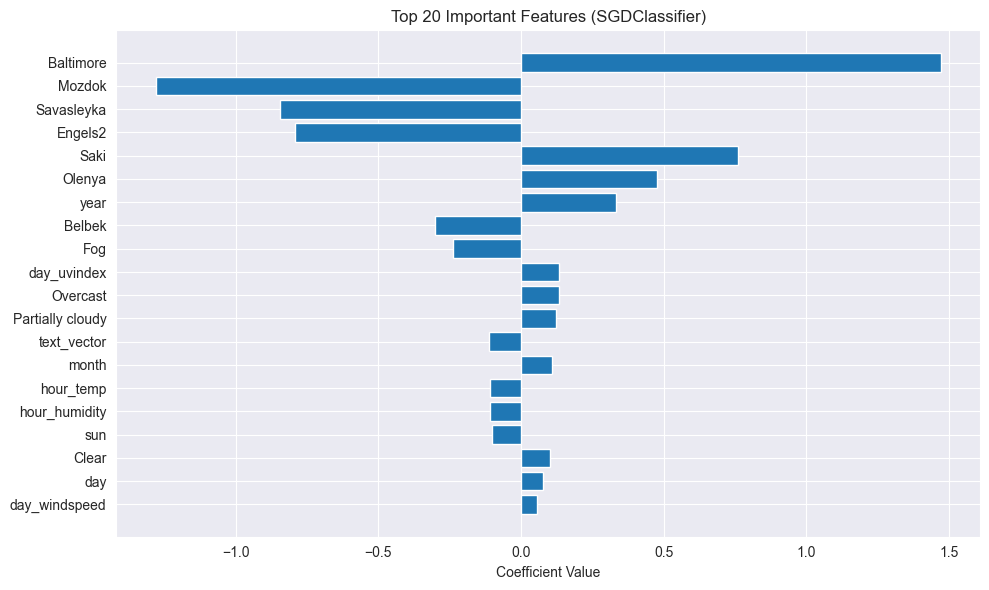

In [75]:
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Important Features (SGDClassifier)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [76]:
y_pred = final_model.predict(x_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Alarm", "Alarm"]))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

    No Alarm       0.70      0.71      0.71    100407
       Alarm       0.71      0.70      0.70    100549

    accuracy                           0.70    200956
   macro avg       0.70      0.70      0.70    200956
weighted avg       0.70      0.70      0.70    200956


Confusion Matrix:

[[71169 29238]
 [30240 70309]]


In [77]:
model_path = '6__SGD__classifier__v8.pkl'
joblib.dump(final_model, model_path)
print(f"Model saved as {model_path}")

Model saved as 6__SGD__classifier__v8.pkl


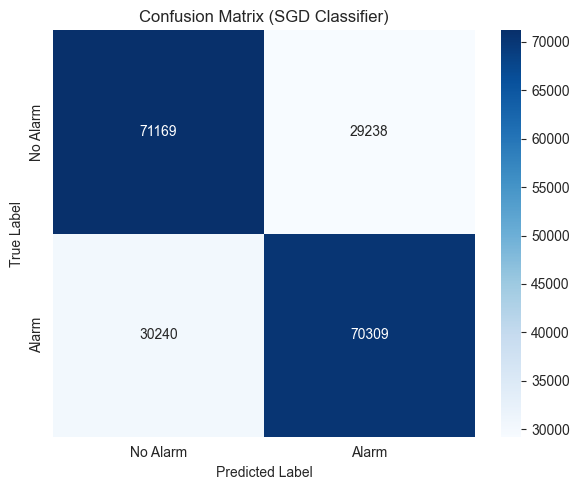

In [80]:
cm = confusion_matrix(y_test, y_pred)
labels = ["No Alarm", "Alarm"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SGD Classifier)")
plt.tight_layout()
plt.show()